In [12]:
using Pkg
Pkg.activate("../Tambo/")
using Tambo
using JLD2

  Activating project at `~/research/TAMBO-MC/Tambo`
┌ Info: Precompiling Tambo [d9a96183-4919-46da-8188-64ea4e10e0ed]
└ @ Base loading.jl:1664


In [41]:
desc = "200bands"
d = load("/Users/jlazar/Downloads/test_simulator_$(desc).jld2")
injection_events = d["injected_events"]
proposal_events = d["proposal_events"];

In [51]:
simulation_config = SimulationConfig(n=200_000, θmin=0, θmax=π/2, emin=1e5*units.GeV, emax=1e8units.GeV)
injector = Tambo.Injector(simulation_config)
geo = Tambo.Geometry(simulation_config);

In [43]:
checks = Tambo.should_do_corsika.(proposal_events, Ref(geo); check_mode=true);

In [49]:
es = 10 .^ LinRange(3, 7, 17) .* units.GeV
θs = acos.(LinRange(1, 0, 6))
ϕs = LinRange(0, 1, 9);

In [50]:
emasks = []
for (emin, emax) in zip(es, es[2:end])
    mask = (
        emin .< getfield.(getfield.(injection_events, :final_state), :energy) .&&
        getfield.(getfield.(injection_events, :final_state), :energy) .< emax
    )
    push!(emasks, mask)
end

θmasks = []
for (θmin, θmax) in zip(θs, θs[2:end])
    mask = [
        θmin .< getfield.(getfield.(getfield.(injection_events, :final_state), :direction), :θ) .&&
        getfield.(getfield.(getfield.(injection_events, :final_state), :direction), :θ) .< θmax
    ]
    push!(θmasks, mask)
end

ϕmasks = []
for (ϕmin, ϕmax) in zip(ϕs, ϕs[2:end])
    mask = [
        ϕmin .< getfield.(getfield.(getfield.(injection_events, :final_state), :direction), :ϕ) .&&
        getfield.(getfield.(getfield.(injection_events, :final_state), :direction), :ϕ) .< ϕmax
    ]
    push!(ϕmasks, mask)
end

In [53]:
weights = Tambo.oneweight.(injection_events, Ref(injector), Ref(injector.xs));

In [ ]:
flux = 

In [26]:
a = zeros((length(θs)-1, length(es)-1, 7))
for (jdx, (θmin, θmax)) in enumerate(zip(θs, θs[2:end]))
    for (idx, (emin, emax)) in enumerate(zip(es, es[2:end]))
        mask = (
            emin .< getfield.(getfield.(injection_events, :final_state), :energy) .&&
            getfield.(getfield.(injection_events, :final_state), :energy) .< emax .&&
            θmin .< getfield.(getfield.(getfield.(injection_events, :final_state), :direction), :θ) .&&
            getfield.(getfield.(getfield.(injection_events, :final_state), :direction), :θ) .< θmax
        )
        evts = proposal_events[mask]
        checks = Tambo.should_do_corsika.(evts, Ref(geo); check_mode=true)
        res = zeros(7)
        for check in checks
            res += check
        end
        a[jdx, idx, :] = res / sum(mask)

    end
end

In [27]:
using Plots
include("../paperstyle.jl")

no_bg_dark! (generic function with 1 method)

In [28]:
cents = (es[1:end-1] + es[2:end]) / 2;

In [29]:
check_names = [
    "check_inside_mtn",
    "check_right_direction",
    "check_plane_dot",
    "check_near_orthogonal",
    "check_z_intercept",
    "check_track_length",
    "check_intersections"
]

7-element Vector{String}:
 "check_inside_mtn"
 "check_right_direction"
 "check_plane_dot"
 "check_near_orthogonal"
 "check_z_intercept"
 "check_track_length"
 "check_intersections"

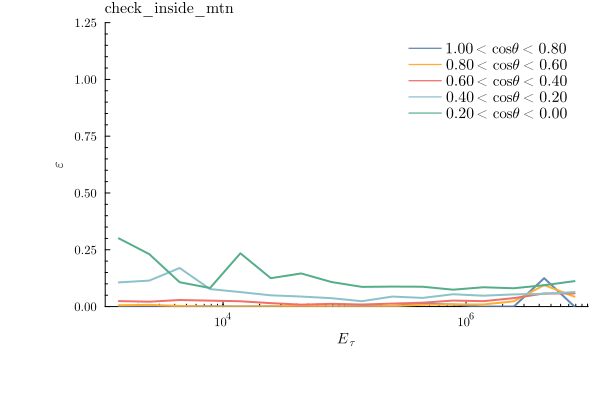

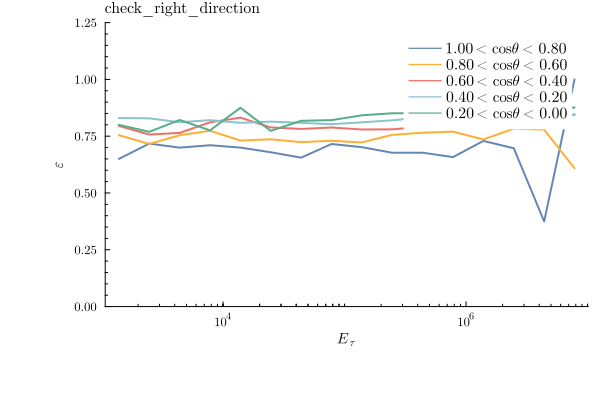

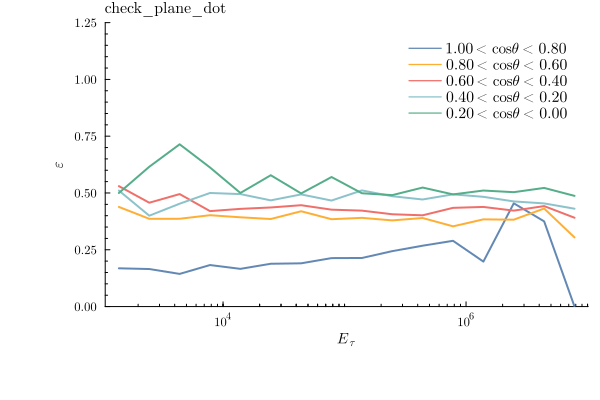

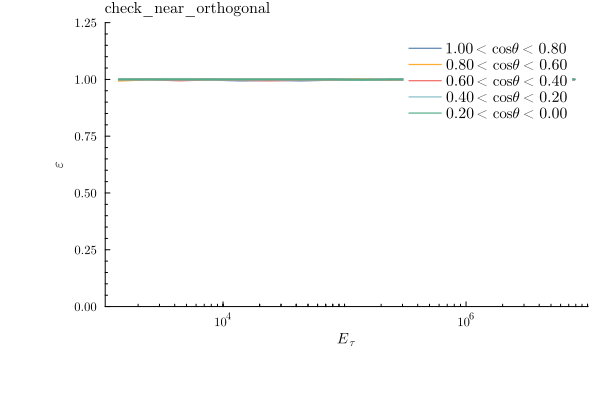

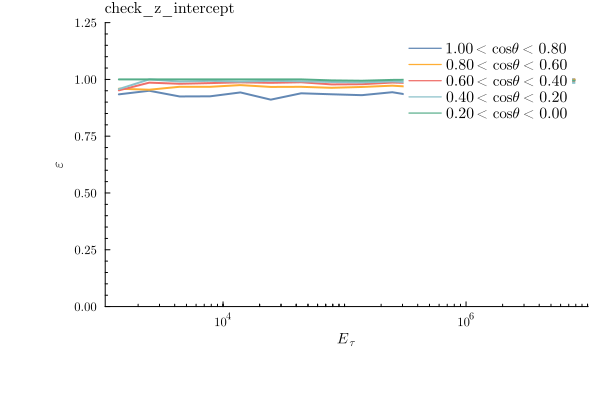

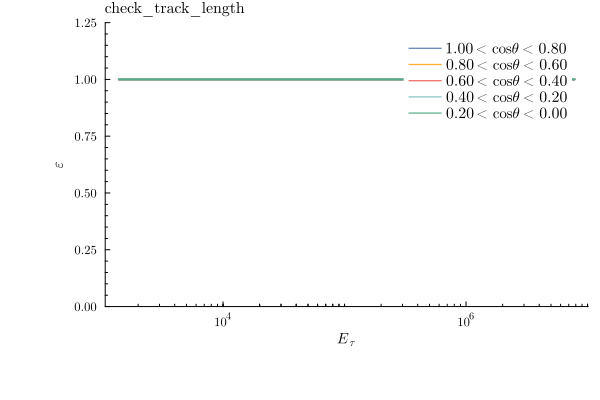

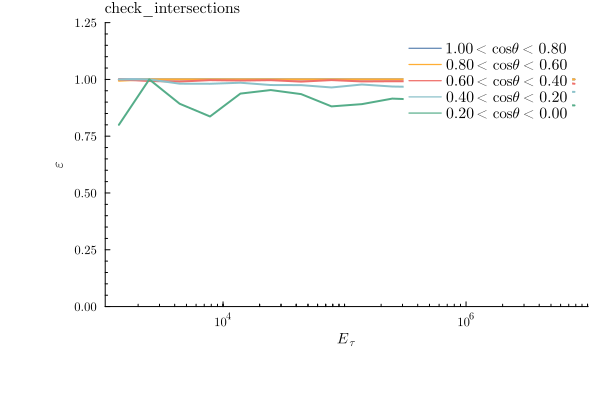

In [30]:
for jdx in 1:7
    plt = plot(
        xscale=:log,
        ylims=(0,1.25),
        leftmargin=1.3cm,
        bottommargin=1.3cm,
        rightmargin=1mm,
        ylabel=L"\epsilon",
        title=check_names[jdx],
        xlabel=L"$E_{\tau}$",
        size=(600, 400)
    )
    for idx in 1:length(θs)-1
        θmin, θmax = θs[idx], θs[idx+1]
        label = (@sprintf "%.2f" cos(θmin)) * L"$<\cos\theta<$" * (@sprintf "%.2f" cos(θmax))
        plot!(plt, cents / units.GeV, a[idx, :, jdx], label=label)
    end
    

    display(plt)
    savefig(plt, "../figures/$(check_names[jdx])_$(desc).pdf")
end

In [ ]:
using StatsBase

h.weights = [4, 8, 54, 125, 319, 902, 2055, 4438, 7703, 9808, 9301, 4091, 931, 97, 4]
h.weights = [6, 12, 43, 144, 341, 911, 2163, 4410, 7537, 11714, 8406, 3742, 751, 51, 1]
h.weights = [8, 20, 73, 151, 481, 1243, 2736, 5057, 10974, 9896, 6459, 2534, 501, 62]
h.weights = [2, 4, 22, 58, 194, 491, 1131, 2416, 9196, 9236, 8115, 5482, 2547, 1082]
h.weights = [1, 3, 11, 30, 76, 191, 453, 7060, 7295, 7200, 6767, 5807, 4863]


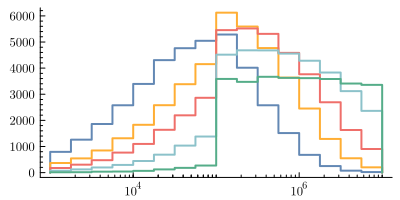

In [224]:
plt = plot(xscale=:log10)
zeniths = getfield.(getfield.(getfield.(injection_events, :entry_state), :direction), :θ)
for (θmin, θmax) in zip(θs, θs[2:end])
    mask = θmin .< zeniths .&& zeniths .< θmax
    evts = injection_events[mask]
    energies = getfield.(getfield.(evts, :entry_state), :energy)
    h = fit(Histogram, log.(10, energies/units.GeV))
    # @show cents
    @show h.weights

    stephist!(plt, energies/units.GeV, bins=es/units.GeV)
end
display(plt)

In [186]:
maximum(zeniths)

0.6434172573639073